<a href="https://colab.research.google.com/github/SumitUttam/Sucidal_Ideation_Tensorflow/blob/main/CNN_Train_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Stress Analysis")

In [ ]:
batch_size = 32
class_names = ["Normal_Posts","Depressed_Posts"]
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory( "Train",
                                                                    batch_size=batch_size,
                                                                    class_names = class_names,
                                                                    validation_split=0.2,
                                                                    subset="training",
                                                                    seed=1337,
                                                                    shuffle = True,
                                                                )
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(   "Train",
                                                                    batch_size=batch_size,
                                                                    class_names = class_names,
                                                                    validation_split=0.2,
                                                                    subset="validation",
                                                                    seed=1337,
                                                                    shuffle = False,
                                                                )

Found 12610 files belonging to 3 classes.
Using 10088 files for training.
Found 12610 files belonging to 3 classes.
Using 2522 files for validation.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"four armed gunmen vs. a four-armed gunman vs. four armed gun-men vs. a four-armed gunman vs. a glocktopus.\n \nfour armed gunmen, a four-armed gunman, four armed gun-men, four-armed gun-man, and a glocktopus decide to put there lead where there mouth is and decide which of them are truly the best gunslingers\n\n&#x200B;\n\nThe four armed gunmen are average 30 year-old men each with \\[a berretta M9\\]([https://www.military.com/equipment/m9-pistol](https://www.military.com/equipment/m9-pistol))\n\nthe four-armed gunman is a man with 4 arms and the same gun in each hand. He is omni-dexterous and can reload 2 of the guns at a time.\n\nthe four armed gun-men are average 30 year old men with Beretta M9s for heads aswell. They maintain all there senses, letting them see and hear the foes,  can fire there gun-heads, which passively reload over a few seconds as opposed to being manually reloaded. They don't harm themselves by doing this, but are still effected by the recoil. And the lack of 

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped = tf.strings.regex_replace(lowercase, "\n", " ")
    return tf.strings.regex_replace(
        stripped, "[%s]" % re.escape(string.punctuation), ""
    )

# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 1000

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

print("Making text-only dataset")
# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
print("adapting vector layer")
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

Making text-only dataset
adapting vector layer


In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)

In [ ]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.3)(x)

# Conv1D + global max pooling
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 14, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a fully connected hidden layers:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a 3 unit output layer, and squash it with a softmax:
predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         229632    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         458880    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [ ]:
epochs = 10



# Fit the model using the train and test datasets.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
316/316 [==============================] - 13s 43ms/step - loss: 0.0336 - accuracy: 0.9896 - val_loss: 0.7562 - val_accuracy: 0.8596
Epoch 2/10
316/316 [==============================] - 13s 40ms/step - loss: 0.0366 - accuracy: 0.9896 - val_loss: 0.3426 - val_accuracy: 0.9274
Epoch 3/10
316/316 [==============================] - 13s 40ms/step - loss: 0.0275 - accuracy: 0.9924 - val_loss: 0.5443 - val_accuracy: 0.9088
Epoch 4/10
316/316 [==============================] - 13s 40ms/step - loss: 0.0260 - accuracy: 0.9939 - val_loss: 0.7216 - val_accuracy: 0.8981
Epoch 5/10
316/316 [==============================] - 12s 39ms/step - loss: 0.0175 - accuracy: 0.9937 - val_loss: 0.5199 - val_accuracy: 0.9227
Epoch 6/10
316/316 [==============================] - 12s 39ms/step - loss: 0.0233 - accuracy: 0.9944 - val_loss: 0.6726 - val_accuracy: 0.9171
Epoch 7/10
316/316 [==============================] - 13s 40ms/step - loss: 0.0195 - accuracy: 0.9951 - val_loss: 0.7564 - val_accuracy:

In [ ]:
model.evaluate(val_ds)

79/79 [==============================] - 1s 8ms/step - loss: 0.9153 - accuracy: 0.9013


[0.9152780771255493, 0.9012688398361206]

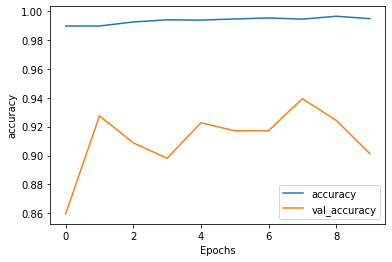

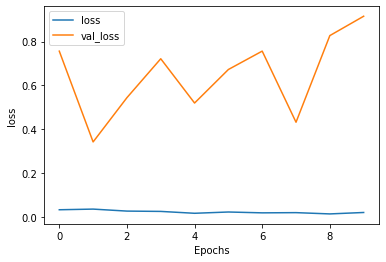

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
model.save('5_model_0.h5')

In [ ]:
model.save('6model_0.tf')

INFO:tensorflow:Assets written to: 6model_0.tf/assets


In [ ]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_val_ds)

79/79 [==============================] - 3s 38ms/step - loss: 0.4854 - accuracy: 0.9080


[0.4854448437690735, 0.9080095291137695]

In [ ]:
end_to_end_model.save("end_to_end_002.tf")

INFO:tensorflow:Assets written to: end_to_end_002.tf/assets


In [ ]:
#predict function
def predict_post(string):
    pred = end_to_end_model.predict(string)
    print(pred)
    print (np.argmax(pred))
    print (class_names[np.argmax(pred)])

In [ ]:
text = ['Just a discussion\n \nI was just wondering how hallowed be thy name fits so perfectly with this game . \n"I\'m waiting in my cold cell, when the bells begins to chime".']


In [ ]:
classes = ['Normal','Depressed','Suicidal']
from os import walk
import pandas as pd

Posts = []
for i in classes:
    for (dirpath, dirnames, filenames) in walk("Train/"+i+"_Posts"):
        for filename in filenames:
            temp = open(dirpath+"/"+filename , 'r')
            tr = temp.read()
            Posts.append([i,tr])
            print("\n"+i+": "+filename)
            temp.close()

Posts = pd.DataFrame(Posts,columns = ['class','Post'])
Posts.to_csv('TrainLabels.csv',index=False)

Streaming output truncated to the last 5000 lines.

Depressed: 00003977.txt

Depressed: 00003978.txt

Depressed: 00003979.txt

Depressed: 00003980.txt

Depressed: 00003981.txt

Depressed: 00003982.txt

Depressed: 00003983.txt

Depressed: 00003984.txt

Depressed: 00003985.txt

Depressed: 00003986.txt

Depressed: 00003987.txt

Depressed: 00003988.txt

Depressed: 00003989.txt

Depressed: 00003990.txt

Depressed: 00003991.txt

Depressed: 00003992.txt

Depressed: 00003993.txt

Depressed: 00003994.txt

Depressed: 00003995.txt

Depressed: 00003996.txt

Depressed: 00003997.txt

Depressed: 00003998.txt

Depressed: 00003999.txt

Depressed: 00004000.txt

Depressed: 00004001.txt

Depressed: 00004002.txt

Depressed: 00004003.txt

Depressed: 00004004.txt

Depressed: 00004005.txt

Depressed: 00004006.txt

Depressed: 00004007.txt

Depressed: 00004008.txt

Depressed: 00004009.txt

Depressed: 00004010.txt

Depressed: 00004011.txt

Depressed: 00004012.txt

Depressed: 00004013.txt

Depressed: 00004014.txt

In [ ]:
Posts = pd.DataFrame(Posts,columns = ['class','Post'])
Posts.to_csv('TrainLabels.csv',index=False)